In [1]:
########################################################################
########################################################################
##                                                                    ##
##                      ORIGINAL _ DO NOT PUBLISH                     ##
##                                                                    ##
########################################################################
########################################################################

import torch as tr
import torch
from torch.nn.functional import pad
import torch.nn as nn
import numpy as np
import loader as ld
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


batch_size = 32
output_size = 2
hidden_size = 8        # to experiment with

run_recurrent = True    # else run Token-wise MLP
use_RNN = False          # otherwise GRU
atten_size = 0          # atten > 0 means using restricted self atten

reload_model = False
num_epochs = 10
learning_rate = 0.0001
test_interval = 300

# Loading sataset, use toy = True for obtaining a smaller dataset

train_dataset, test_dataset, num_words, input_size = ld.get_data_set(batch_size)

# Special matrix multipication layer (like torch.Linear but can operate on arbitrary sized
# tensors and considers its last two indices as the matrix.)

class MatMul(nn.Module):
    def __init__(self, in_channels, out_channels, use_bias = True):
        super(MatMul, self).__init__()
        self.matrix = torch.nn.Parameter(torch.nn.init.xavier_normal_(torch.empty(in_channels,out_channels)), requires_grad=True)
        if use_bias:
            self.bias = torch.nn.Parameter(torch.zeros(1,1,out_channels), requires_grad=True)

        self.use_bias = use_bias

    def forward(self, x):        
        x = torch.matmul(x,self.matrix) 
        if self.use_bias:
            x = x+ self.bias 
        return x


class ExRestSelfAtten(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, atten_size=5):
        super(ExRestSelfAtten, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.sqrt_hidden_size = np.sqrt(float(hidden_size))
        self.ReLU = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax(dim=2)
        self.atten_size = atten_size
        
        # Token-wise MLP + Restricted Attention network implementation
        self.layer1 = MatMul(input_size, hidden_size)
        self.W_q = MatMul(hidden_size, hidden_size, use_bias=False)
        self.W_k = MatMul(hidden_size, hidden_size, use_bias=False)
        self.W_v = MatMul(hidden_size, hidden_size, use_bias=False)
        self.layer2 = MatMul(hidden_size, output_size)

        # Positional encoding
        self.positional_encoding = nn.Parameter(torch.randn(batch_size, num_words, input_size))

    def name(self):
        return "MLP_atten"

    def forward(self, x):
        # Add positional encoding
        x = x + self.positional_encoding[:x.shape[0],:,:]

        # Token-wise MLP + Restricted Attention network implementation
        x = self.layer1(x)
        x = self.ReLU(x)

        # generating x in offsets between -atten_size and atten_size 
        # with zero padding at the ends
        padded = pad(x, (0, 0, self.atten_size, self.atten_size, 0, 0))

        x_nei = []
        for k in range(-self.atten_size, self.atten_size + 1):
            x_nei.append(torch.roll(padded, k, 1))

        x_nei = torch.stack(x_nei, 2)
        x_nei = x_nei[:, self.atten_size:-self.atten_size, :]

        # Applying attention layer
        queries = self.W_q(x).unsqueeze(2)
        keys = self.W_k(x_nei)
        values = self.W_v(x_nei)

        # Compute attention scores
        atten_scores = torch.matmul(queries, keys.transpose(-2, -1)) / self.sqrt_hidden_size
        atten_weights = self.softmax(atten_scores)

        # Apply attention weights
        atten_output = torch.matmul(atten_weights, values).squeeze(2)

        # Pass through final linear layer
        output = self.layer2(atten_output)

        return output, atten_weights


# prints portion of the review (20-30 first words), with the sub-scores each work obtained
# prints also the final scores, the softmaxed prediction values and the true label values

def print_review(rev_text, sbs1, sbs2, lbl1, lbl2):
    for i in range(len(rev_text)):
        print(f'for word: {rev_text[i]}, prediction was: {"1" if bool(sbs1[i] > sbs2[i]) else "0"}, true label is: {"1" if bool(lbl1 > lbl2) else "0"}')

/home/orian/PycharmProjects/deepLearning/.venv/lib/python3.10/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/orian/PycharmProjects/deepLearning/.venv/lib/python3.10/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/orian/PycharmProjects/deepLearning/.venv/lib/python3.10/site-packages/torchtext

Using model: MLP_atten
Accuracy: 0.5
Epoch [1/10], Step [300/938], Train Loss: 0.8585, Test Loss: 0.7752
Accuracy: 0.59375
Epoch [1/10], Step [600/938], Train Loss: 0.7473, Test Loss: 0.7158
Accuracy: 0.5
Epoch [1/10], Step [900/938], Train Loss: 0.7468, Test Loss: 0.7154
Accuracy: 0.625
Epoch [2/10], Step [300/938], Train Loss: 0.7466, Test Loss: 0.6843
Accuracy: 0.4375
Epoch [2/10], Step [600/938], Train Loss: 0.6735, Test Loss: 0.6811
Accuracy: 0.46875
Epoch [2/10], Step [900/938], Train Loss: 0.7518, Test Loss: 0.6943
Accuracy: 0.65625
Epoch [3/10], Step [300/938], Train Loss: 0.6410, Test Loss: 0.6708
Accuracy: 0.4375
Epoch [3/10], Step [600/938], Train Loss: 0.7389, Test Loss: 0.7281
Accuracy: 0.6875
Epoch [3/10], Step [900/938], Train Loss: 0.6414, Test Loss: 0.6195
Accuracy: 0.53125
Epoch [4/10], Step [300/938], Train Loss: 0.6140, Test Loss: 0.6329
Accuracy: 0.59375
Epoch [4/10], Step [600/938], Train Loss: 0.6684, Test Loss: 0.6614
Accuracy: 0.625
Epoch [4/10], Step [900/938]

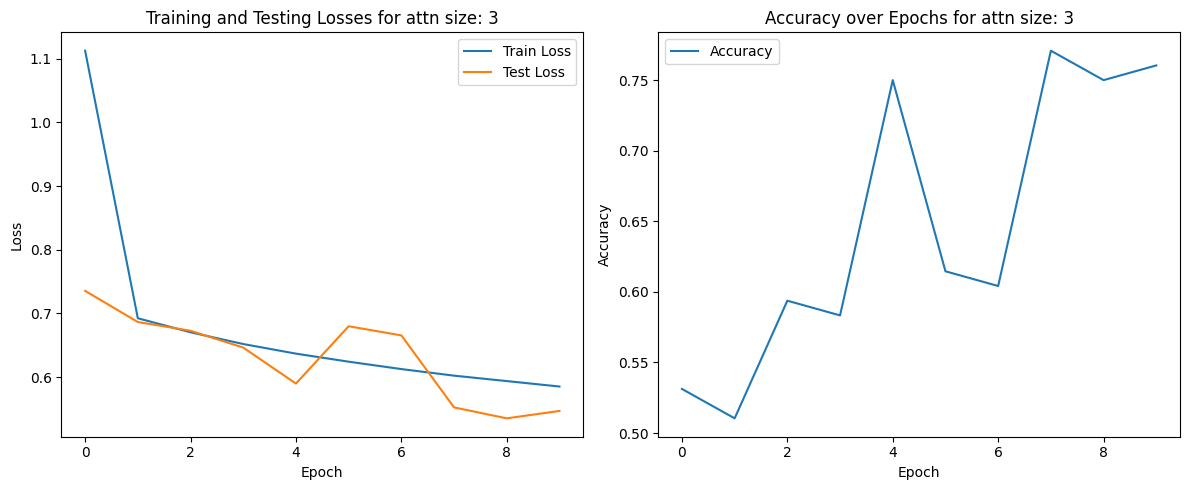

Using model: MLP_atten
Accuracy: 0.5625
Epoch [1/10], Step [300/938], Train Loss: 1.2351, Test Loss: 1.2917
Accuracy: 0.4375
Epoch [1/10], Step [600/938], Train Loss: 0.8908, Test Loss: 0.9794
Accuracy: 0.5625
Epoch [1/10], Step [900/938], Train Loss: 0.7631, Test Loss: 0.9608
Accuracy: 0.65625
Epoch [2/10], Step [300/938], Train Loss: 0.8082, Test Loss: 0.6488
Accuracy: 0.625
Epoch [2/10], Step [600/938], Train Loss: 0.8272, Test Loss: 0.7855
Accuracy: 0.46875
Epoch [2/10], Step [900/938], Train Loss: 0.7244, Test Loss: 0.7964
Accuracy: 0.59375
Epoch [3/10], Step [300/938], Train Loss: 0.8588, Test Loss: 0.6386
Accuracy: 0.6875
Epoch [3/10], Step [600/938], Train Loss: 0.7198, Test Loss: 0.6232
Accuracy: 0.65625
Epoch [3/10], Step [900/938], Train Loss: 0.7462, Test Loss: 0.7530
Accuracy: 0.71875
Epoch [4/10], Step [300/938], Train Loss: 0.7214, Test Loss: 0.6107
Accuracy: 0.6875
Epoch [4/10], Step [600/938], Train Loss: 0.6164, Test Loss: 0.6806
Accuracy: 0.5625
Epoch [4/10], Step [9

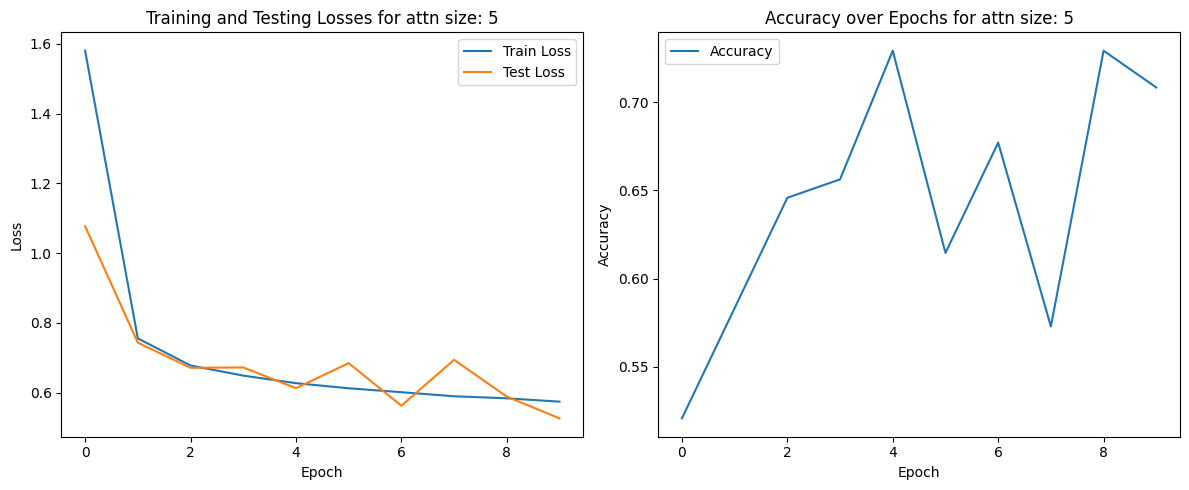

Using model: MLP_atten
Accuracy: 0.65625
Epoch [1/10], Step [300/938], Train Loss: 0.8358, Test Loss: 0.6930
Accuracy: 0.40625
Epoch [1/10], Step [600/938], Train Loss: 0.7331, Test Loss: 0.8073
Accuracy: 0.5
Epoch [1/10], Step [900/938], Train Loss: 0.6992, Test Loss: 0.7531
Accuracy: 0.65625
Epoch [2/10], Step [300/938], Train Loss: 0.5767, Test Loss: 0.6384
Accuracy: 0.46875
Epoch [2/10], Step [600/938], Train Loss: 0.6737, Test Loss: 0.7430
Accuracy: 0.53125
Epoch [2/10], Step [900/938], Train Loss: 0.6511, Test Loss: 0.7035
Accuracy: 0.5625
Epoch [3/10], Step [300/938], Train Loss: 0.6093, Test Loss: 0.6826
Accuracy: 0.5625
Epoch [3/10], Step [600/938], Train Loss: 0.6664, Test Loss: 0.6886
Accuracy: 0.6875
Epoch [3/10], Step [900/938], Train Loss: 0.6163, Test Loss: 0.5896
Accuracy: 0.6875
Epoch [4/10], Step [300/938], Train Loss: 0.6497, Test Loss: 0.5679
Accuracy: 0.65625
Epoch [4/10], Step [600/938], Train Loss: 0.6367, Test Loss: 0.5972
Accuracy: 0.5625
Epoch [4/10], Step [90

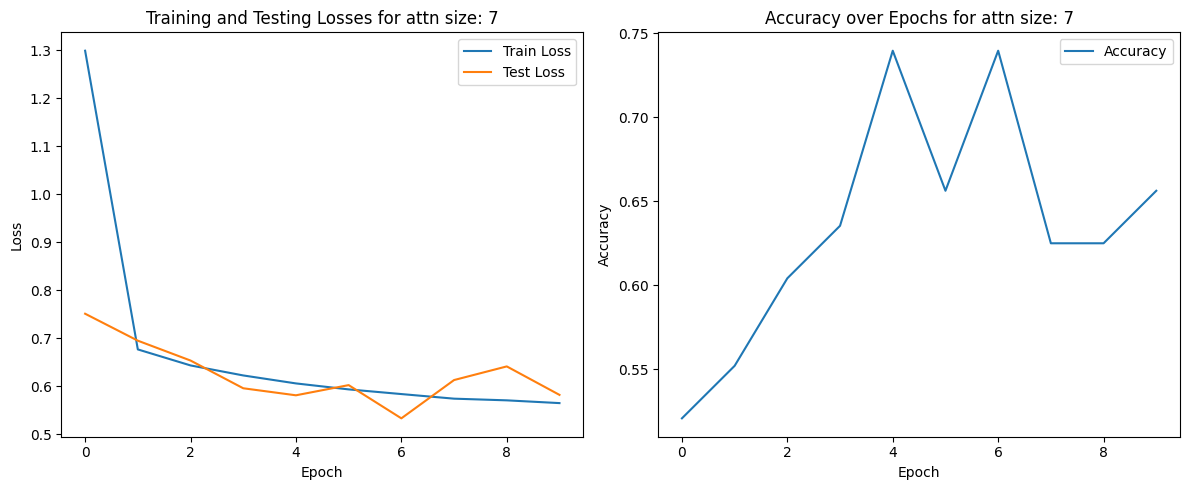

In [2]:
for atten_size in  [3,5,7]:

    model = ExRestSelfAtten(input_size, output_size, hidden_size, atten_size)

    print("Using model: " + model.name())

    if reload_model:
        print("Reloading model")
        model.load_state_dict(torch.load(model.name() + ".pth"))

    model.cuda()

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_loss = 1.0
    test_loss = 1.0

    # training steps in which a test step is executed every test_interval

    model.train()

    train_losses = []
    test_losses = []
    accuracies = []

    for epoch in range(num_epochs):

        itr = 0 # iteration counter within each epoch
        epoch_train_loss = 0
        epoch_test_loss = 0
        epoch_accuracies = []

        for labels, reviews, reviews_text in train_dataset:   # getting training batches

            # test if the model can predict allways False
            # labels = torch.arange(0, 2, dtype=torch.float32).repeat(1024,1).cuda()

            itr = itr + 1

            if (itr + 1) % test_interval == 0:
                test_iter = True
                labels, reviews, reviews_text = next(iter(test_dataset)) # get a test batch 
            else:
                test_iter = False

            # Recurrent nets (RNN/GRU)

            # Token-wise networks (MLP / MLP + Atten.) 

            sub_score, atten_weights = model(reviews)

            output = torch.mean(sub_score, 1)
                
            # cross-entropy loss

            loss = criterion(output, labels)

            # optimize in training iterations

            if not test_iter:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # averaged losses
            if test_iter:
                test_loss = 0.8 * float(loss.detach()) + 0.2 * test_loss
                epoch_test_loss += test_loss
            else:
                train_loss = 0.9 * float(loss.detach()) + 0.1 * train_loss
                epoch_train_loss += train_loss

            if test_iter:
                accuracy = accuracy_score(torch.argmax(output, dim=1).cpu(), torch.argmax(labels, dim=1).cpu())
                epoch_accuracies.append(accuracy)
                print(f"Accuracy: {accuracy}")
                print(
                    f"Epoch [{epoch + 1}/{num_epochs}], "
                    f"Step [{itr + 1}/{len(train_dataset)}], "
                    f"Train Loss: {train_loss:.4f}, "
                    f"Test Loss: {test_loss:.4f}"
                )

                if not run_recurrent:
                    nump_subs = sub_score.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()
                    print_review(reviews_text[0], nump_subs[0,:,0], nump_subs[0,:,1], labels[0,0], labels[0,1])

                # saving the model
                torch.save(model, model.name() + ".pth")

        accuracies.append(sum(epoch_accuracies) / len(epoch_accuracies))    
        train_losses.append(epoch_train_loss / len(train_dataset))
        test_losses.append(epoch_test_loss / (len(train_dataset) // test_interval))


    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(num_epochs), train_losses, label='Train Loss')
    plt.plot(range(num_epochs), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Training and Testing Losses for attn size: {atten_size}')

    plt.subplot(1, 2, 2)
    plt.plot(range(len(accuracies)), accuracies, label='Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'Accuracy over Epochs for attn size: {atten_size}')

    plt.tight_layout()
    plt.show()

In [34]:

from loader import preprocess_review, MAX_LENGTH

model_type = 'MLP_atten'
model = torch.load(f"{model_type}.pth")

review_hard_for_rnn1 = "great movie, best movie ever watched, you should watch it"
review_hard_for_rnn_rep = preprocess_review(review_hard_for_rnn1).cuda()


sub_score, atten_weights = model(review_hard_for_rnn_rep)
output = torch.mean(sub_score.squeeze(), 0)

model_pred = "positive" if output[0] > output[1] else "negative"
model_type = model.name()
print(f'for {model_type} => {model_pred}')


for MLP_atten => positive


In [33]:
review_hard_for_rnn1 = "great movie, best movie ever watched, you should watch it"
review_hard_for_rnn_rep = preprocess_review(review_hard_for_rnn1).cuda()


sub_score, atten_weights = model(review_hard_for_rnn_rep)
output = torch.mean(sub_score.squeeze(), 0)
output

tensor([0.6113, 0.5962], device='cuda:0', grad_fn=<MeanBackward1>)